In [37]:
from quantecon import compute_fixed_point
from numba import njit
import numpy as np
from collections import namedtuple
from quantecon.distributions import BetaBinomial

In [38]:
# NamedTuple Model
Model = namedtuple("Model", ("n", "w_vals", "φ", "β", "c"))


def create_job_search_model(
        n=50,        # wage grid size
        w_min=10.0,  # lowest wage
        w_max=60.0,  # highest wage
        a=200,       # wage distribution parameter
        b=100,       # wage distribution parameter
        β=0.96,      # discount factor
        c=10.0       # unemployment compensation
    ):
    """
    Creates the parameters for job search model and returns the
    instance of namedtuple Model
    """
    w_vals = np.linspace(w_min, w_max, n+1)
    φ = BetaBinomial(n, a, b).pdf()
    return Model(n=n, w_vals=w_vals, φ=φ, β=β, c=c)

In [39]:
# A model with default parameters
default_model = create_job_search_model()

# Just in time compiler -- compile the function so it runs faster
# Decorator to compile the function
@njit
def T(v, model):
    """ The Bellman operator. """
    n, w_vals, φ, β, c = model
    return np.array([np.maximum(w / (1 - β),
                    c + β * np.sum(v * φ)) for w in w_vals])

In [40]:
@njit
def get_greedy(v, model):
    """ Get a v-greedy policy. """
    n, w_vals, φ, β, c = model
    σ = w_vals / (1 - β) >= c + β * np.sum(v * φ)  # Boolean policy vector
    return σ


def vfi(model):
    """ Solve the infinite-horizon IID job search model by VFI. """
    v_init = np.zeros_like(model.w_vals)
    v_star = compute_fixed_point(lambda v: T(v, model), v_init,
                                 error_tol=1e-5, max_iter=1000, print_skip=25)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star



In [41]:
vfi(model=default_model)

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
23           9.192e-06      2.839e-01         
Converged in 23 steps


(array([1085.74289014, 1085.74289014, 1085.74289014, 1085.74289014,
        1085.74289014, 1085.74289014, 1085.74289014, 1085.74289014,
        1085.74289014, 1085.74289014, 1085.74289014, 1085.74289014,
        1085.74289014, 1085.74289014, 1085.74289014, 1085.74289014,
        1085.74289014, 1085.74289014, 1085.74289014, 1085.74289014,
        1085.74289014, 1085.74289014, 1085.74289014, 1085.74289014,
        1085.74289014, 1085.74289014, 1085.74289014, 1085.74289014,
        1085.74289014, 1085.74289014, 1085.74289014, 1085.74289014,
        1085.74289014, 1085.74289014, 1100.        , 1125.        ,
        1150.        , 1175.        , 1200.        , 1225.        ,
        1250.        , 1275.        , 1300.        , 1325.        ,
        1350.        , 1375.        , 1400.        , 1425.        ,
        1450.        , 1475.        , 1500.        ]),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, F

In [5]:
import matplotlib.pyplot as plt


def fig_vseq(model=default_model,
                k=3,
                savefig=False,
                figname="./figures/iid_job_search_1.pdf",
                fs=10):

    v = np.zeros_like(model.w_vals)
    fig, ax = plt.subplots(figsize=(9, 5.5))
    for i in range(k):
        ax.plot(model.w_vals, v, linewidth=3, alpha=0.6,
                label=f"iterate {i}")
        v = T(v, model)

    for i in range(1000):
        v = T(v, model)

    ax.plot(model.w_vals, v, "k-", linewidth=3.0,
            label="iterate 1000", alpha=0.7)

    fontdict = {'fontsize': fs}
    ax.set_xlabel("wage offer", fontdict=fontdict)
    ax.set_ylabel("lifetime value", fontdict=fontdict)

    ax.legend(fontsize=fs, frameon=False)

    if savefig:
        fig.savefig(figname)
    plt.show()

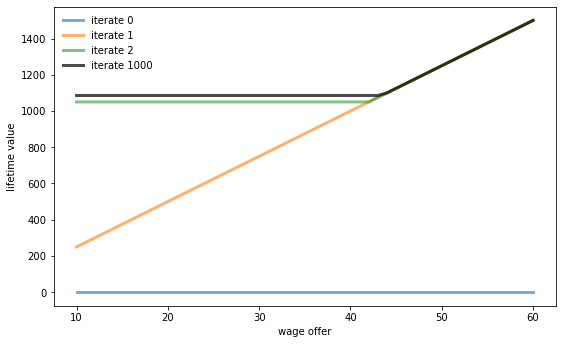

In [6]:
fig_vseq()

## Different discount factor $\beta$

In [35]:
default_model = create_job_search_model(β=0.6)

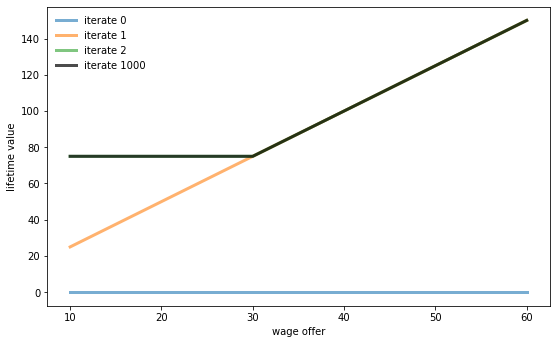

In [36]:
fig_vseq(default_model)

## Different reservation wage $c$

In [33]:
default_model = create_job_search_model(β=0.96,c=20)

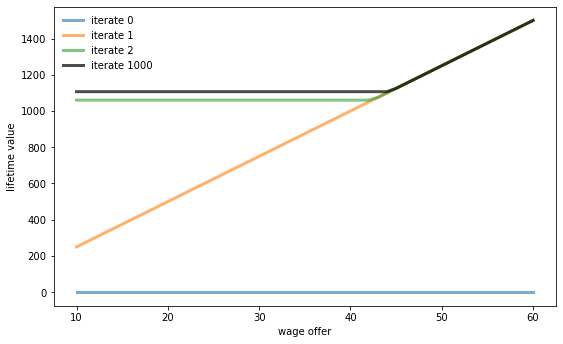

In [34]:
fig_vseq(default_model)

In [42]:
def fig_vstar(model,
              savefig=False, fs=10,
              figname="./figures/iid_job_search_3.pdf"):
    """ Plot the fixed point. """
    n, w_vals, φ, β, c = model
    v_star, σ_star = vfi(model)

    fig, ax = plt.subplots(figsize=(9, 5.5))
    ax.plot(w_vals, v_star, "k-", linewidth=1.5, label="value function")
    cont_val = c + β * np.sum(v_star * φ)
    ax.plot(w_vals, [cont_val]*(n+1),
            "--",
            linewidth=5,
            alpha=0.5,
            label="continuation value")

    ax.plot(w_vals,
            w_vals / (1 - β),
            "--",
            linewidth=5,
            alpha=0.5,
            label=r"$w/(1 - \beta)$")

    ax.legend(frameon=False, fontsize=fs, loc="lower right")

    if savefig:
        fig.savefig(figname)
    plt.show()

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
23           9.192e-06      4.305e-03         
Converged in 23 steps


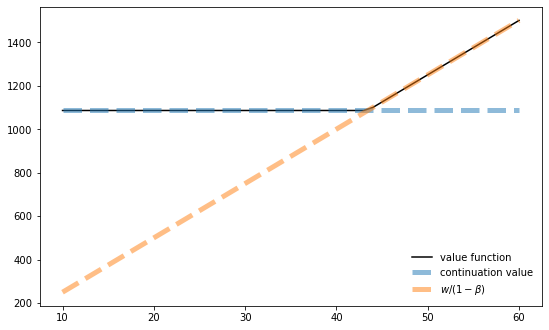

In [43]:
fig_vstar(model=default_model)